# Mooring data for this example is acquired from the [KEO Ocean Climate Station](https://www.pmel.noaa.gov/ocs/data-overview).

In [1]:
import numpy as np
import xarray as xr
import xrft 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ds = xr.open_dataset('data/sst32n145e_dy.cdf')
ds

<xarray.Dataset>
Dimensions:  (depth: 1, lat: 1, lon: 1, time: 5721)
Coordinates:
  * time     (time) datetime64[ns] 2004-06-16T12:00:00 ... 2020-02-13T12:00:00
  * depth    (depth) float32 1.0
  * lat      (lat) float32 32.3
  * lon      (lon) float32 144.6
Data variables:
    T_25     (time, depth, lat, lon) float32 ...
    QT_5025  (time, depth, lat, lon) float32 ...
    ST_6025  (time, depth, lat, lon) float32 ...
Attributes:
    Data_Source:    OCS Project Office/NOAA/PMEL
    OCS:            Dr. Meghan F. Cronin: Meghan.F.Cronin@noaa.gov
    File_info:      Contact: Dai.C.McClurg@noaa.gov
    missing_value:  1e+35
    _FillValue:     1e+35
    CREATION_DATE:  18:32 15-FEB-2020

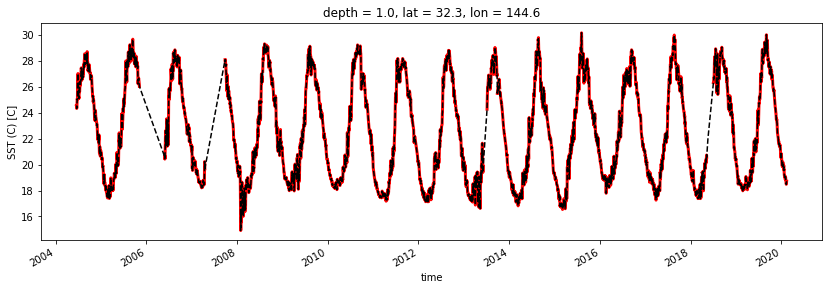

In [3]:
t_masked = ds.T_25.where(ds.T_25<40.).dropna(dim='time')
t_interp = t_masked.interp(time=ds.time, method='slinear')

fig, ax = plt.subplots(figsize=(14,4))
ds.T_25.where(ds.T_25<40.).plot(ax=ax, c='r', lw=3)
t_interp.plot(ax=ax, ls='--', c='k')

We can calculate the periodogram from the entire time series or assume ergodicity and chunk the time series before calculating the spectrum.

In [4]:
df1 = xrft.power_spectrum(t_interp, dim='time', window=True, detrend='constant')
df2 = xrft.power_spectrum(t_interp.sel(time=slice('2005-01-04','2019-12-31')).chunk({'time':1095}), 
                          dim='time', chunks_to_segments=True, 
                          window=True, detrend='constant')
df3 = xrft.power_spectrum(t_interp.sel(time=slice('2005-01-04','2019-12-31')) 
                          * xr.DataArray(np.tile(np.hanning(len(df2.freq_time)),len(df2.time_segment)), dims=['time']), 
                          dim='time', detrend='constant')
df2

<xarray.DataArray 'rechunk-merge-fb0222c43304140c5f9b6b3ac35c11bf' (time_segment: 5, freq_time: 1095, depth: 1, lat: 1, lon: 1)>
dask.array<truediv, shape=(5, 1095, 1, 1, 1), dtype=float64, chunksize=(1, 1095, 1, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * time_segment       (time_segment) int64 0 1 2 3 4
  * depth              (depth) float32 1.0
  * lat                (lat) float32 32.3
  * lon                (lon) float32 144.6
  * freq_time          (freq_time) float64 -5.782e-06 -5.771e-06 ... 5.782e-06
    freq_time_spacing  float64 1.057e-08

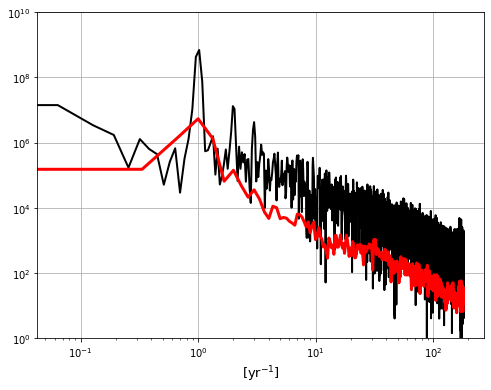

In [5]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(df1.freq_time*365*86400, df1[:,0,0,0], 'k', lw=2)
ax.plot(df2.freq_time*365*86400, df2.mean('time_segment')[:,0,0,0], 'r', lw=3)
# ax.plot(df3.freq_time*365*86400, df3[:,0,0,0], 'g--', lw=1)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'[yr$^{-1}$]', fontsize=13)
ax.set_ylim([1,10**10])
ax.grid(True)

The spectra pick up the annual frequency ($f=1 \text{yr}^{-1}$). The red spectrum calculated by chunking the time series into segments results in overall lower power due to the Hanning window being applied to each segment. 